*This notebook has been **significantly** modified from the original notebook available online, as detailed next. This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*<br>
*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Unsupervised clustering: k-Means

We have previously explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.<br>
>**Unsupervised, clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.**

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

>**The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.**

It accomplishes this using a simple conception of what the optimal clustering looks like:

- **The "cluster center" is the arithmetic mean of all the points belonging to the cluster;**
- **Each point is closer to its own cluster center than to any other cluster centers.**

Those two assumptions are the basis of the *k*-means model.

**For now let's take a look at a simple dataset and see the *k*-means result:**
- Let's generate a two-dimensional dataset containing four distinct blobs;
- We will leave the labels out of the visualization (to emphasize that this is an unsupervised algorithm).

C:\Users\ALiotta\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


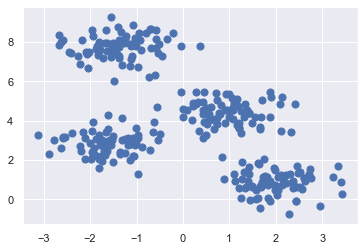

In [2]:
# The make_blobs() function can be used to generate blobs of points with a Gaussian distribution.

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

#print(X)
# X includes the x,y coordinates of all points

#print(y_true)
# y_true contains the class labels (0, 1, 2, 3) that we ignore for the time being to 
# make this an unsupervised learning problem (no labels are used next)

plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
from sklearn.cluster import KMeans

# we are asking K-means to fit the data to 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
# y_kmeans are the predicted cluster labels (0, 1, 2, 3)
y_kmeans = kmeans.predict(X)
#print (y_kmeans)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

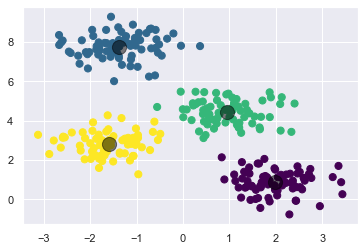

In [4]:
# plotting data points with cluster colors y_kmeans
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# plotting the 4 cluster centres computed by K-means
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, **the number of possible combinations of cluster assignments is exponential in the number of data points**—an exhaustive search would be very, very costly.
Fortunately for us, such an **exhaustive search is not necessary**: instead, 

>**the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.**<br>
It´s some form of trial-and-error process

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.

**In short, the expectation–maximization approach here consists of the following procedure:**
>1. **Guess some cluster centers**<br>
>2. **Repeat until converged**<br>
>   2.1.***E-Step*: assign points to the nearest cluster center**<br>
>   2.2.***M-Step*: set the cluster centers to the mean**<br>

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: 
>**under *typical* circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.**

We can visualize the algorithm as shown in the following figure.

**For the particular initialization shown here, the clusters converge in just three iterations**:

![(run code in Appendix to generate image)](figures/05.11-expectation-maximization.png)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
>**The following is a very basic implementation of *K*-Means:**

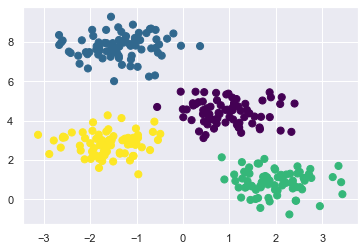

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### Caveat 1: The globally optimal result may not always be achieved (e.g. if we hit a local minimum)
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

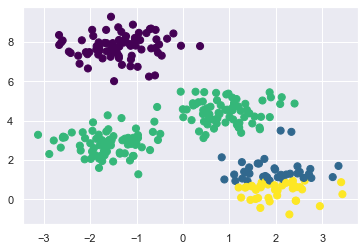

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. 

>**Strategy to hit global minima**: it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### Caveat 2: The number of clusters must be selected beforehand (it cannot be learned)
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
>For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

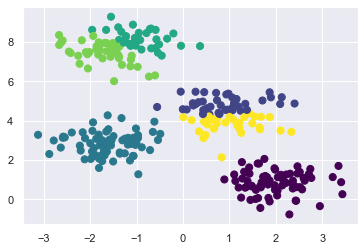

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

>**Strategy 1:** to identify number of clusters, one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

>**Strategy 2:** use a more complilcated clustering algorithm, which has a better quantitative measure of the fitness per number of clusters. For instance: Gaussian mixture models.

>**Strategy 3:** use an algorithm that *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule).

#### Caveat 3: k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that **the algorithm will often be ineffective if the clusters have complicated geometries**.

>**The boundaries between *k*-means clusters will always be linear**, which means that it will fail for more complicated boundaries.

Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

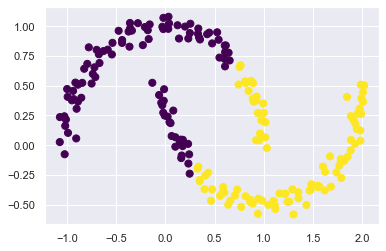

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

>**Strategy to fit non-linear data**: use kernel transformations.

This situation is reminiscent of Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

>**Spectral Clustering**: One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
( [see spectral clustering documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)). 
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

C:\Users\ALiotta\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


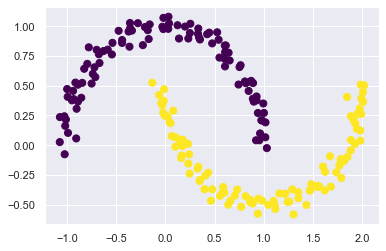

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### Options for the ``affinity`` matrix
- ``nearest_neighbors``: construct the affinity matrix by computing a graph of nearest neighbors.
- ``rbf``: construct the affinity matrix using a radial basis function (RBF) kernel.
- ``precomputed``: interpret X as a precomputed affinity matrix, where larger values indicate greater similarity between instances.

#### Caveat 4: k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed

>**Strategy to speed-up *k*-Means**: just use a subset of the data to update the cluster centers at each step.<br>
This is the idea behind **batch-based *k*-means algorithms**, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``.

## Example: ``k-means`` on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in Principal Component Analysis.<br>
>**Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information***.<br>
This might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.<br>
>**However, we prior knowledge about the dataset which has 10 digits --> we can try with 10 clusters**

>We will start by loading the digits and then finding the ``KMeans`` clusters.<br>
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

>**The result is 10 clusters in 64 dimensions**.<br>
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

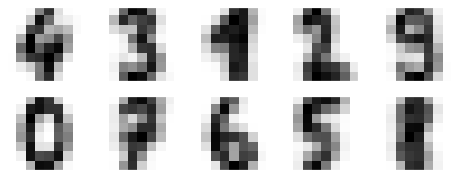

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
# reshapes the ten 64-dimentional centers (10,64) to ten 8x8 centers (10, 8, 8) > 64 pixels
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    # .imshow() plots the pixels as images
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps some exceptions.

>To check on the accuracy, let´s first match each learned cluster label with the true labels:

In [14]:
# scipy.stats.mode() returns an array of the modal (most common) value in the passed array.
# If there is more than one such value, only the smallest is returned.
from scipy.stats import mode

# np.zeros_like() returns an array of zeros with the same shape and type as the `clusters` array
labels = np.zeros_like(clusters)

# sets the labels[] to the ones predicted
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!

>Let's check the confusion matrix for this:

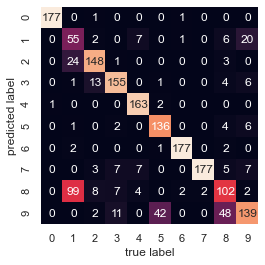

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.

>But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!